20240306

SarahFong

Take output from DiffBind deseq2 formatting

          $HOME/EMF/US/bin/ATAC/1_prep_deseq2_ATAC.ipynb 
          
Prepare data: 
1. Load data per cl
2. Apply filters for min conc, quantile inclusion, jointaccessibility based on min conc, class labeling
3. Split into training, validation and test set - hold out chr12 for validation, chr8 for testing
4. Optional-Downsample training data
6. Shuffle and Add fold num to training set

In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pbt

from scipy import stats

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
config_name =os.path.join(os.getcwd(), "config.multi.ini")
config, cfn = crw.read(config_name)

# functions

In [3]:
def setPrefixRules(prefix):
    """ rules for processing datasets"""
    if "class.all" in prefix:
        QUANTILE_FILTER=False  # don't remove top quantile
        MIN_CONC_FILTER=True  # do require peak to meet min conc threshold in one of conditions
        JOINT_ACCESSIBLE=True  # do keep joint accessible elements
        CLASS_LABEL = True  # label classes w/deseq2 for classification tasks

    elif "class.nojoint" in prefix:
        QUANTILE_FILTER=False
        MIN_CONC_FILTER=True
        JOINT_ACCESSIBLE=False  # remove joint accessible elements
        CLASS_LABEL = True

    elif "reg.all" in PREFIX:
        QUANTILE_FILTER=False
        MIN_CONC_FILTER=True
        JOINT_ACCESSIBLE=True
        CLASS_LABEL = False  # use min_conc values for regression task

    elif "reg.nojoint" in prefix:
        QUANTILE_FILTER=False
        MIN_CONC_FILTER=True
        JOINT_ACCESSIBLE=False  # remove joint accessible elements
        CLASS_LABEL = False  # use min_conc values for regression task
    else:
        print('need to add rules for', prefix)
        
    return QUANTILE_FILTER, MIN_CONC_FILTER, JOINT_ACCESSIBLE, CLASS_LABEL


## make chromosome list

In [4]:
def chrList():
    """return  list of chromosomes"""
    
    chrs = []
    
    for n in np.arange(1,23):
        chrs.append(f"chr{n}")
    
    # add sex chromosomes
    chrs.append("chrX")
    chrs.append("chrY")
    
    return chrs

## write fa

In [5]:
def writeFa(heldout_df, heldout_fa):
    with open(heldout_fa, "w") as writer:
        for row in heldout_df.iterrows():
            seqid, seq=row[1][:2]
            writer.write(f">{seqid}\n{seq}\n")

## train test split on chromosome

In [6]:
def splitTrainTestVal(df, val_chr_list=None, test_chr_list=None):
    """randomly sample and hold out 2 chromosomes for testing, validation"""
    
    cols =['coor.type',"seq"]
    
    # randomly sample test chromosomes (n=2)
    if test_chr_list is None:
        print('randomly sampling chromosomes for test')


        # randomly sample
        test_chr_list = list(np.random.choice(chrs, 2))
   
    # randomly sample validation chromosome (n=1)
    if val_chr_list is None:
        print('randomly sampling chromosomes for val')

        # remove test chromosomes
        for chr_ in test_chr_list:
            chrs.remove(chr_)

        # randomly sample
        val_chr_list = list(np.random.choice(chrs, 1))

    # separate held out chromosomes from  training chromosomes
    test = df.loc[df["#chr"].isin(test_chr_list)].copy()
    val = df.loc[df["#chr"].isin(val_chr_list)].copy()
    train = df.loc[(~df["#chr"].isin(test_chr_list))&
                  (~df["#chr"].isin(val_chr_list))].copy()

    return train, val, test


## filters

In [64]:
def minConcFilter(table, min_conc, filter_bool=True):
    """Filter control and US atac for a min concentration threshold
        Require threshold in control OR ultrasound, but both not necessary (differentially accessible)
    """
    if filter_bool is True:
        print("before minconc filter:", table.shape)
        table = table.loc[(table["ctrl"] > min_conc) |
                          (table["US"] > min_conc)].copy()
        print("after:", table.shape)
    else:
        print("no min conc filtering")

    return table


def quantileFilter(table, filter_bool=False, quantile=0.99):
    """upper quantile filter for read count values. Only upper because lower threshold is zero."""

    if filter_bool is True:
        print("before quantile filter:", table.shape)

        # quantiles
        ctrl_thresh, us_thresh = table[["ctrl", "US"]].quantile(quantile)

        # filter table
        table = table.loc[(table["ctrl"] < ctrl_thresh) &
                          (table["US"] < us_thresh)]

        print("after:", table.shape)
    else:
        print("no quantile filter")

    return table


def jointAccessibleFilter(table, filter_bool=True):
    """remove joint accessible regions, scramble new dataframe"""

    if filter_bool is False:
        print("before joint_accessible filter:", table.shape)

        # filter table
        ctrl_only = table.loc[(table["ctrl"] > 0) &
                              (table["US"] == 0)].copy()

        US_only = table.loc[(table["ctrl"] == 0) &
                            (table["US"] > 0)].copy()

        # combine us and ctrl, shuffle dataframe
        table = dfShuffle(pd.concat([ctrl_only, US_only]))

        print("after:", table.shape)
    else:
        print('keeping jointly accessible elements')

    return table

# label based on min_conc value
def minConcClassLabel(table):
    """ RETIRED-binarize read count column based on min_conc"""
    cols_to_label = ['ctrl', 'US']
    for col in cols_to_label:
        table[col] = table[col].apply(lambda x: 0 if x<MIN_CONC else 1)

    return table

# label deseq2 DiffAcc peaks
def diffAccLabel(table, diff_bed, filter_bool=False):
    """ Annotate elements that overlap desseq2 differentially accessible peak calls
        Intersect peaks w/ DESEQ2 differentially accessible peaks.
        Label any peak with 1+ bp overlapping DESEQ2 element. 
        Return dataframe of overlapping elements. 
    """
    if filter_bool is True:
        print("labeling peaks overlapping deseq2 diffAcc by >=1 bp")
        table_bed = pbt.BedTool.from_dataframe(table[table.columns[:4]])
        deseq_bed = pbt.BedTool(diff_bed)

        # intersect table x deseq2, write all present, absent overlaps. 
        table_deseq = table_bed.intersect(deseq_bed, wao=True)

        # load intersection results
        table_deseq = pd.read_csv(table_deseq.fn, sep='\t', header=None)
        table_deseq.columns=['#chr', "start_trim", "end_trim", "type", 
                             "#chr_deseq", "start_deseq", "end_deseq", 
                             "deseq_id", "diffAcc"
                            ]

        # if peak overlaps DESEQ2 element by 1+ bp 
        # annotate diffAcc overlap as 1 or 0 
        table_deseq["diffAcc"] = table_deseq["diffAcc"].apply(lambda x: 1 if x>=1 else 0) 

        # merge annotations with original table
        table = pd.merge(table, table_deseq[["type","diffAcc"]]).drop_duplicates()
    else:
        print('not labeling deseq2-overlapping peaks. What is your label again?')
    
    # return dataframe w/ names and deseq2 overlaps
    return table


# scramble df
def dfShuffle(df):
    """scramble dataframe"""
    return df.sample(frac=1).reset_index(drop=True)


# sequences where US increases activity only
def directionFilter(table, filter_bool=False):
    """filter for positive directional changes in activity"""
    if filter_bool is True:
        print('include sequences that increase activity w US')
        table = table.loc[table["US_DIF"]<0] #where US_DIF = ctrl - US, and US_dif <0 means US has more activity than control
        
    else:
        print('include ALL sequences that increase|decrease|no activity change w US')
    return table


# downsample
def downsampleNegClass(train, filter_bool=False):
    """downsample training set only"""
    
    if filter_bool is True:
        # get positive and negatives
        pos, neg = train.loc[train["diffAcc"]>0].copy(), train.loc[train["diffAcc"]==0].copy()

        # count the positive examples
        n_pos = pos.shape[0] # ctrl - US <0 means US has more activity than control

        print("downsampling training data!\n percent with a positive label:", 
              round(n_pos/train.shape[0], 2), 
              "\n"
             )

        # randomly sample negative examples
        neg_downsample = neg.sample(n=n_pos)

        # return concatenated dataframe of downsampled negative class. 
        return pd.concat([pos, neg_downsample])

# Main

## params

In [65]:
PREFIX = "class.all.1task"  
PATH = "/wynton/group/ahituv/data/US-MPRA/ATAC-seq/Diffbind_results"
TEST_CHR = ["chr1"]
VAL_CHR = "chr12"


# peak information
PEAK_SIZE = 270
MIN_CONC = 2  #NOTE -  $HOME/EMF/US/bin/ATAC/1_prep_deseq2_ATAC.ipynb may have pre-filtered the min_conc value
DIRECTION_FILTER = False  # keep only positive changes? Negative changes? 
DOWNSAMPLE=True

# genome information
HG38= "/wynton/group/ahituv/data/dna/hg38/hg38.chrom.sizes"
FA_HG38="/wynton/group/ahituv/data/dna/hg38/hg38.fa"

## load data + filter per cell line 

In [67]:
# collect cell-specific annotations
train_dict, val_dict, test_dict = {}, {}, {}

# set columns 
if "class" in PREFIX:
    # classification task
    cols=["coor.type", "diffAcc"]
else:
    # regression task
    cols = ["coor.type","US","ctrl", # "US_DIF"
           ]

fa_cols = ['coor.type', "seq"]


for CL in ["hob", "hepg2", "k562", "bj"]:  #CL = 'hob'
    print(CL)
            
    # Instantiate cell- and task-specific path.
    DATA_PATH = f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}/{PREFIX}"
    
    # make cl- and task-specific datapath
    if os.path.exists(DATA_PATH) is False:
        if os.path.dirname(DATA_PATH) is False:
            os.mkdir(os.path.dirname(DATA_PATH))
        os.mkdir(DATA_PATH)


    ## cell-specific base files

    # DESEQ2 files
    DIFF = f'./{CL}_deseq2.csv'
    NODIFF = f'./{CL}_deseq2-nodiff.csv'
    DIFF_BED = "./" + DIFF.strip(".csv") + ".bed"

    # FULL peakset called from deseq2, trimmed to 270bp. 
    FULL = f"{CL}_deseq2-nondiff.trimmed.min_conc.{MIN_CONC}.full.csv"

    
    ### Write CONFIG FILE ###
    ## base config
    section = f"{CL}-ATAC-DESEQ2"
    crw.check(config, section)

    config[section]["path"] = PATH

    config[section]["nondiff_bind_results"] = "%(path)s/" + NODIFF
    config[section]["diff_bind_results"] = "%(path)s/" + DIFF
    config[section]["diff_bind_results_bed"] = "%(path)s/" + DIFF_BED


    ## deepstarr files

    # file inputs for training, testing
    TRAIN_FA = f"{PREFIX}.Sequences_Train.fa"
    VAL_FA = f"{PREFIX}.Sequences_Val.fa"
    TEST_FA = f"{PREFIX}.Sequences_Test.fa"

    ## y
    TRAIN_TARGET = f"{PREFIX}.Sequences_activity_Train.txt"
    VAL_TARGET = f"{PREFIX}.Sequences_activity_Val.txt"
    TEST_TARGET = f"{PREFIX}.Sequences_activity_Test.txt"

    ## rules

    ## deepstarr config 
    section = f"{CL}.atac.deseq2.deepstarr"
    crw.check(config, section)

    config[section]["data_path"] = DATA_PATH
    config[section]["held_out_chr"] = ",".join(TEST_CHR)
    config[section]["val_chr"] = VAL_CHR

    ## deepstarr+prefix config

    # rules for data
    QUANTILE_FILTER, MIN_CONC_FILTER, JOINT_ACCESSIBLE, CLASS_LABEL = setPrefixRules(PREFIX)

    # deepstarr prefix config
    section = f"{CL}.atac.deseq2.deepstarr.{PREFIX}"
    crw.check(config, section)

    config[section]["train_fa"] = TRAIN_FA
    config[section]["val_fa"] = VAL_FA
    config[section]["test_fa"] = TEST_FA

    config[section]["train_target"] = TRAIN_TARGET
    config[section]["tval_target"] = VAL_TARGET
    config[section]["test_target"] = TEST_TARGET

    config[section]["filter_MIN_CONC"] = str(MIN_CONC_FILTER)
    if MIN_CONC_FILTER is True:
        config[section]["MIN_CONC"] = str(MIN_CONC)

    config[section]["filter_quantile"] = str(QUANTILE_FILTER)
    config[section]["filter_jointaccessible"] = str(JOINT_ACCESSIBLE)
    config[section]["classlabel"] = str(CLASS_LABEL)

    crw.write(config, cfn)

    ### load data ###
    os.chdir(PATH)
    table = pd.read_csv(FULL, sep='\t').drop_duplicates()

    table["coor.type"] = table["type"] + "|" + table["seq.id"]

    if "Conc_Ultrasound_dif" not in list(table):
        table["Conc_Ultrasound_dif"] = table["Conc_Control"] - \
            table["Conc_Ultrasound"]

    table.rename(columns={"Conc_Ultrasound": "US",
                          "Conc_Control": "ctrl",
                          "Conc_Ultrasound_dif": "US_DIF"}, inplace=True)
    
    # remove alternative chromosome alignments
    table = table.loc[~table['#chr'].str.contains('v')]

    print("original dataset shape", table.shape)

    ### FILTER ###

    ## mean read depth filter
    # remove noisy peaks with low read counts. 
    table = minConcFilter(table, MIN_CONC, MIN_CONC_FILTER) 

    ## quantile filter - remove any peaks above the quantile. 
    # important for regression-task
    table = quantileFilter(table, QUANTILE_FILTER, quantile=0.99)

    ## joint accessible filter
    table = jointAccessibleFilter(table, JOINT_ACCESSIBLE)

    ## apply class label—1 if CONC>MIN_CONC, 0 if CONC<MIN_CONC

    table = diffAccLabel(table, DIFF_BED, CLASS_LABEL)
    #print(table.groupby(['ctrl', "US", "US_DIF", "diffAcc"])['#chr'].count())

    # filter for us-increasing sequences? 
    table = directionFilter(table, DIRECTION_FILTER)

    # annotate which cl this is
    table["cl"]=CL

    ### TRAIN TEST SPLIT ###
    ## train on atac peaks
    os.chdir(DATA_PATH)

    table = dfShuffle(table)  # shuffle the table before splitting

    train, val, test = splitTrainTestVal(table, val_chr_list=[VAL_CHR], test_chr_list=TEST_CHR)
    
    print("positives in val, test", val.groupby("diffAcc")["seq"].count(), test.groupby("diffAcc")["seq"].count())
    
    # downsample training data
    train = downsampleNegClass(train, DOWNSAMPLE)

    writeFa(test[fa_cols], TEST_FA)
    writeFa(train[fa_cols], TRAIN_FA)
    writeFa(val[fa_cols], VAL_FA)
        

    test[cols].to_csv(TEST_TARGET, sep='\t', index=False)
    train[cols].to_csv(TRAIN_TARGET, sep='\t', index=False)
    val[cols].to_csv(VAL_TARGET, sep='\t', index=False)
    print(val.shape, train.shape, test.shape, "\n\n")

    train_dict[CL], val_dict[CL], test_dict[CL] = train, val, test

hob
original dataset shape (156659, 10)
before minconc filter: (156659, 10)
after: (156659, 10)
no quantile filter
keeping jointly accessible elements
labeling peaks overlapping deseq2 diffAcc by >=1 bp
ctrl       US         US_DIF     diffAcc
0.000000   2.031034   -2.031034  0          1
           2.034355   -2.034355  0          1
           2.108923   -2.108923  0          1
           2.109045   -2.109045  0          1
           2.117857   -2.117857  0          2
                                           ..
10.519145  10.680225  -0.161080  0          1
10.523657  10.680369  -0.156712  0          1
10.527785  10.750965  -0.223180  0          1
10.549858  10.750119  -0.200261  0          1
10.632526  10.815728  -0.183202  0          1
Name: #chr, Length: 155410, dtype: int64
include ALL sequences that increase|decrease|no activity change w US
positives in val, test diffAcc
0    7349
1      94
Name: seq, dtype: int64 diffAcc
0    13898
1      198
Name: seq, dtype: int64
downsamplin

# combine training, test data across cell types. 

## config - write

In [118]:
DATA_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/all/class.all.balanced"
if os.path.exists(DATA_PATH) is False:
    os.mkdir(DATA_PATH)
os.chdir(DATA_PATH)
CL = "allcl"
PREFIX="general"


# file inputs for training, testing
TRAIN_FA = f"{PREFIX}.Sequences_Train.fa"
VAL_FA = f"{PREFIX}.Sequences_Val.fa"
TEST_FA = f"{PREFIX}.Sequences_Test.fa"

## y
TRAIN_TARGET = f"{PREFIX}.Sequences_activity_Train.txt"
VAL_TARGET = f"{PREFIX}.Sequences_activity_Val.txt"
TEST_TARGET = f"{PREFIX}.Sequences_activity_Test.txt"

## rules

## deepstarr config 
section = f"{CL}.atac.deseq2.deepstarr"
crw.check(config, section)

config[section]["data_path"] = DATA_PATH
config[section]["held_out_chr"] = ",".join(TEST_CHR)
config[section]["val_chr"] = VAL_CHR

# deepstarr prefix config
section = f"{CL}.atac.deseq2.deepstarr.{PREFIX}"
crw.check(config, section)

config[section]["train_fa"] = TRAIN_FA
config[section]["val_fa"] = VAL_FA
config[section]["test_fa"] = TEST_FA

config[section]["train_target"] = TRAIN_TARGET
config[section]["tval_target"] = VAL_TARGET
config[section]["test_target"] = TEST_TARGET

config[section]["filter_MIN_CONC"] = str(MIN_CONC_FILTER)
if MIN_CONC_FILTER is True:
    config[section]["MIN_CONC"] = str(MIN_CONC)

config[section]["filter_quantile"] = str(QUANTILE_FILTER)
config[section]["filter_jointaccessible"] = str(JOINT_ACCESSIBLE)
config[section]["classlabel"] = str(CLASS_LABEL)

crw.write(config, cfn)

## concat dictionaries

In [119]:
train_full = pd.concat(train_dict.values())
val_full = pd.concat(val_dict.values())
test_full = pd.concat(test_dict.values())

## write full tables

In [120]:
# write fasta
writeFa(test_full[fa_cols], TEST_FA)
writeFa(train_full[fa_cols], TRAIN_FA)
writeFa(val_full[fa_cols], VAL_FA)

# write fasta
test_full[cols].to_csv(TEST_TARGET, sep='\t', index=False)
train_full[cols].to_csv(TRAIN_TARGET, sep='\t', index=False)
val_full[cols].to_csv(VAL_TARGET, sep='\t', index=False)

# report nrows
train_full.shape[0], val_full.shape[0], test_full.shape[0]

(8100, 20718, 42573)

## table pivot 
- 1 = diff accessible element. 
- 0 = not dif accessible OR NOT accessible. This might be a problem, as some sequences may be predicted zero because they are not differentially accessible or because they are not present in a cell type at all. 


### Experimental question
- should US-sensitivity be predicted as a cell-type-specific task? or just in general?

    - One hypothesis for in general: DA elements have sequence similarity between cell lines, but are accessible at different loci depending on cell-type. This suggests similar trans-regulatory responses, but cis-regulatory effects that are cell-type-specific. In this case, predicting DA based on sequence, regardless of cell type, is an appropriate classification task. 
    
    - One hypothesis for in cl-specific: DA elements have distinct sequences across cell lines and are accessible at different loci depending on cell-type. This would suggest different trans-regulatory responses per cell line, producing different cis-regulatory effects that are cell-type-specific. In this case, predicting DA based on both sequence AND cell type is appropriate. 

In [122]:
DATA_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/all/class.all.balanced"
if os.path.exists(DATA_PATH) is False:
    os.mkdir(DATA_PATH)
os.chdir(DATA_PATH)
CL = "allcl-stratified"
PREFIX="cl-specific"


# file inputs for training, testing
TRAIN_FA = f"{PREFIX}.Sequences_Train.fa"
VAL_FA = f"{PREFIX}.Sequences_Val.fa"
TEST_FA = f"{PREFIX}.Sequences_Test.fa"

## y
TRAIN_TARGET = f"{PREFIX}.Sequences_activity_Train.txt"
VAL_TARGET = f"{PREFIX}.Sequences_activity_Val.txt"
TEST_TARGET = f"{PREFIX}.Sequences_activity_Test.txt"

## rules

## deepstarr config 
section = f"{CL}.atac.deseq2.deepstarr"
crw.check(config, section)

config[section]["data_path"] = DATA_PATH
config[section]["held_out_chr"] = ",".join(TEST_CHR)
config[section]["val_chr"] = VAL_CHR

# deepstarr prefix config
section = f"{CL}.atac.deseq2.deepstarr.{PREFIX}"
crw.check(config, section)

config[section]["train_fa"] = TRAIN_FA
config[section]["val_fa"] = VAL_FA
config[section]["test_fa"] = TEST_FA

config[section]["train_target"] = TRAIN_TARGET
config[section]["tval_target"] = VAL_TARGET
config[section]["test_target"] = TEST_TARGET

config[section]["filter_MIN_CONC"] = str(MIN_CONC_FILTER)
if MIN_CONC_FILTER is True:
    config[section]["MIN_CONC"] = str(MIN_CONC)

config[section]["filter_quantile"] = str(QUANTILE_FILTER)
config[section]["filter_jointaccessible"] = str(JOINT_ACCESSIBLE)
config[section]["classlabel"] = str(CLASS_LABEL)

crw.write(config, cfn)

In [128]:
# pivot tables. 
train_full_table=pd.pivot(train_full, columns = "cl", index="coor.type", values="diffAcc").fillna(0).reset_index()
val_full_table=pd.pivot(val_full, columns = "cl", index="coor.type", values="diffAcc").fillna(0).reset_index()
test_full_table=pd.pivot(test_full, columns = "cl", index="coor.type", values="diffAcc").fillna(0).reset_index()

# add sequences bak
train_full_table=pd.merge(train_full[["coor.type", "seq"]], train_full_table)
val_full_table=pd.merge(val_full[["coor.type", "seq"]], val_full_table)
test_full_table=pd.merge(test_full[["coor.type", "seq"]], test_full_table)

### write pivot tables

In [143]:
# write fasta
writeFa(test_full_table[fa_cols], TEST_FA)
writeFa(train_full_table[fa_cols], TRAIN_FA)
writeFa(val_full_table[fa_cols], VAL_FA)

# write target
cols = list(test_full_table.columns)
cols.remove("seq")

test_full_table[cols].to_csv(TEST_TARGET, sep='\t', index=False)
train_full_table[cols].to_csv(TRAIN_TARGET, sep='\t', index=False)
val_full_table[cols].to_csv(VAL_TARGET, sep='\t', index=False)

# report nrows
train_full_table.shape[0], val_full_table.shape[0], test_full_table.shape[0]

(8100, 20718, 42573)

### side quest - DiffAcc elements are cell type-specific 

In [69]:
# there are no training examples where a regulatory element has US sensitive activity >1 cell type. See col 0
train_full_table.sum(axis=1).reset_index().sort_values(by=0, ascending=False)  

,coor.type,0
8099,k562.9|chr2:171598770-171599041,1.0
6276,hob.7609|chr11:2471850-2472121,1.0
3490,hob.131|chr7:84194994-84195265,1.0
3489,hob.1319|chr9:129838741-129839012,1.0
6226,hob.737|chr7:134793016-134793287,1.0
...,...,...
3350,hob.125505|chr13:95628567-95628838,0.0
3349,hob.125419|chr4:76558468-76558739,0.0
3348,hob.125367|chr6:79813944-79814215,0.0
3347,hob.125358|chr8:11571836-11572107,0.0


(8100, 20718, 42573)

## EDA

### per cell line - N training elements 

[Text(0.5, 1.0, 'Training dataset\nn elements per cell line'),
 Text(0, 0.5, 'n elements')]

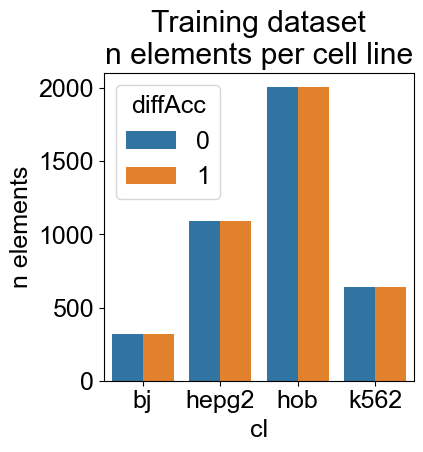

In [85]:
plot = train_full.groupby(["cl", "diffAcc"]).count().reset_index()

# plot
fig, ax=plt.subplots(figsize=(4,4))
sns.barplot(x="cl", y="#chr", data=plot, hue="diffAcc")
ax.set(title="Training dataset\nn elements per cell line", 
      ylabel="n elements")

### per cell line - N test elements 

[Text(0.5, 1.0, 'Test dataset\nn elements per cell line'),
 Text(0, 0.5, 'n elements')]

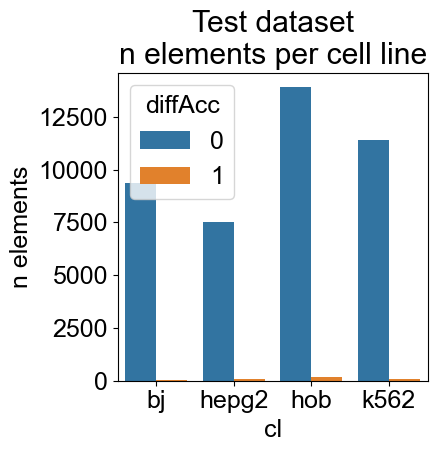

In [102]:
plot = test_full.groupby(["cl", "diffAcc"]).count().reset_index()

# plot
fig, ax=plt.subplots(figsize=(4,4))
sns.barplot(x="cl", y="#chr", data=plot, hue="diffAcc")
ax.set(title="Test dataset\nn elements per cell line", 
      ylabel="n elements")

### per cell line, chromosome, N training elements

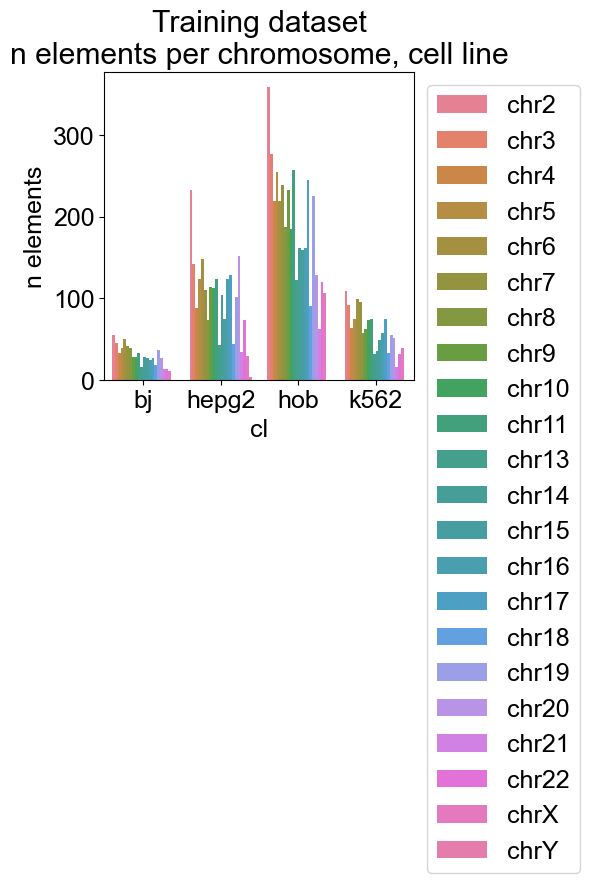

In [101]:
plot = train_full.groupby(["#chr", "cl"]).count().reset_index()

chr_list = chrList()
chr_list.remove(TEST_CHR[0]) 
chr_list.remove(VAL_CHR)

# plot
fig, ax=plt.subplots(figsize=(4,4))
sns.barplot(x="cl", y="start_trim", data=plot, hue="#chr", hue_order=chr_list)
ax.set(title="Training dataset\nn elements per chromosome, cell line", 
      ylabel="n elements")
ax.legend(bbox_to_anchor=(1,1))

[Text(0.5, 1.0, 'Val dataset\nn elements per cell line'),
 Text(0, 0.5, 'n elements')]

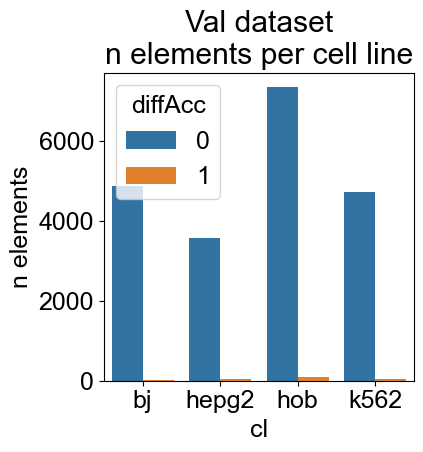

In [104]:
plot = val_full.groupby(["cl", "diffAcc"]).count().reset_index()

# plot
fig, ax=plt.subplots(figsize=(4,4))
sns.barplot(x="cl", y="#chr", data=plot, hue="diffAcc")
ax.set(title="Val dataset\nn elements per cell line", 
      ylabel="n elements")

### peak at training dataframe

In [75]:
train_full.sort_values(by="US")

,#chr,start_trim,end_trim,type,seq.id,US,ctrl,US_DIF,seq,coor.type,diffAcc,cl
56532,chrX,130704419,130704690,hepg2.37,chrX:130704419-130704690,0.000000,3.065094,3.065094,TACATGTACACAGTGTTGGGAGAGATATAGTCATGAGTCATCTGAG...,hepg2.37|chrX:130704419-130704690,1,hepg2
26486,chr16,74738120,74738391,bj.144,chr16:74738120-74738391,0.000000,2.663705,2.663705,CAGAGTAGGCCTCCACATCCTCCCAGGGCCCAGCCCTCGCCCTTCC...,bj.144|chr16:74738120-74738391,1,bj
55425,chr6,33134103,33134374,hepg2.2858,chr6:33134103-33134374,0.000000,2.089445,2.089445,tttccaagaatgtggagggatccttctcagttgtgagatcatgaag...,hepg2.2858|chr6:33134103-33134374,1,hepg2
21276,chr17,82599854,82600125,bj.323,chr17:82599854-82600125,0.000000,2.040915,2.040915,GGCAAGTCCCCCTCCCACATCTCTAGGCACCAGGGCGTAGCGTACC...,bj.323|chr17:82599854-82600125,1,bj
19121,chr8,127859878,127860149,bj.194,chr8:127859878-127860149,0.000000,2.810927,2.810927,CTCTACAAGCAGAGAGGCTGAGTCATACAGATCCTGAGGGGAGATC...,bj.194|chr8:127859878-127860149,1,bj
...,...,...,...,...,...,...,...,...,...,...,...,...
8355,chr17,82022945,82023216,hob.1129,chr17:82022945-82023216,10.235839,10.001215,-0.234624,CCGCGCCCCTAGCCAATGAGTCCGAAGCGCCTGCTCTCGGAGCCCC...,hob.1129|chr17:82022945-82023216,1,hob
90060,chr17,81860739,81861010,hob.298,chr17:81860739-81861010,10.260538,10.034846,-0.225692,CCTGGCCTTCGTTCGGGATTGGCCGAGGACCTCGCGCTCGCTGTCT...,hob.298|chr17:81860739-81861010,1,hob
35023,chr20,31572944,31573215,hob.977,chr20:31572944-31573215,10.281258,10.055790,-0.225469,TATCAGGGGCGGGGCCTCAGGGGCCTGCCCCTGCCTCCCCGCCCTG...,hob.977|chr20:31572944-31573215,1,hob
140941,chr19,797032,797303,hob.16060,chr19:797032-797303,10.319324,10.197688,-0.121636,CAGGCGGGCGGGTCCTGCCCACTTGCAAGATGGCGGCAGCCTGGGC...,hob.16060|chr19:797032-797303,0,hob
